# Spontaneous Alternation Task: Y-Maze

#### Renata Cruz

Behavioral experiment to test short-term memory which takes advantage of the innate exploratory behavior of mice. In short, we use a three-arm Y-maze and record the entries and alternations to the different arms. The arms would be labelled A-B-C.

Entries: All 4 limbs of a mouse are within an arm;
Alternations: Consecutive entries into all three arms;

### Loading Dataset and Preprocessing

For the preprocessing, we need to separate the habituation (first 2 minutes) from the trial (8 minutes). We also need to remove the noise in the entries and the NaNs in the tracking.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load the data

col_names_arms = ['A', 'B','C', 'center', 'n_arms', 'timepoint']
arm_name = ['A', 'B', 'C']

arms = pd.read_csv('/mnt/c/Users/admin/OneDrive/Ambiente de Trabalho/Behavior/RawData/arms_52732021-10-15T14_35_27.csv', names = col_names_arms)

In [3]:
print(arms.shape)
arms.head()

(16787, 6)


,A,B,C,center,n_arms,timepoint
0,True,True,True,True,4,2021-10-15T14:35:27.9840256+01:00
1,False,False,False,False,4,2021-10-15T14:35:28.0618752+01:00
2,False,False,False,False,4,2021-10-15T14:35:28.0951296+01:00
3,False,False,False,False,4,2021-10-15T14:35:28.1381888+01:00
4,False,False,False,False,4,2021-10-15T14:35:28.1644800+01:00


In [4]:
# Encode True/False statements to binary code 1/0

bool_cols = arms.select_dtypes(bool)
arms[bool_cols.columns] = bool_cols.astype(int)

print(arms.head())

   A  B  C  center  n_arms                          timepoint
0  1  1  1       1       4  2021-10-15T14:35:27.9840256+01:00
1  0  0  0       0       4  2021-10-15T14:35:28.0618752+01:00
2  0  0  0       0       4  2021-10-15T14:35:28.0951296+01:00
3  0  0  0       0       4  2021-10-15T14:35:28.1381888+01:00
4  0  0  0       0       4  2021-10-15T14:35:28.1644800+01:00


#### Arms Dataset: Habituation & Experiment

In [5]:
# Change all entries that include the center and where no entry is detected to 'False (0)'. This will maintain the number of frames constant

for arm in arm_name:
    arms[arm][arms['center'] == 1] = 0

print(arms.tail())

       A  B  C  center  n_arms                          timepoint
16782  0  0  0       1       4  2021-10-15T14:44:47.2701184+01:00
16783  0  0  0       1       4  2021-10-15T14:44:47.3030784+01:00
16784  0  0  0       1       4  2021-10-15T14:44:47.3364480+01:00
16785  0  0  0       1       4  2021-10-15T14:44:47.3752320+01:00
16786  0  0  0       1       4  2021-10-15T14:44:47.4083328+01:00


/tmp/ipykernel_522/2674597472.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arms[arm][arms['center'] == 1] = 0


In [56]:
# Change all entries with a high frequency of condition switchs (ex: 0-1-0) to 'False (0)'. These represent noise in the data.

def noise_removal(df, size):
    '''This function will set a window of a given size to roll though the dataframe according to the rows.
    -> size of the window;
    If the median value of the window is 0 (False), it will change any values in the array to 0. If the median value is 1 (True), the array remains unchanged.
    Ex: 
        In: [0-1-0] Out: [0-0-0] # Median = 0
        In: [0-1-1] Out: [0-1-1] # Median = 1
    '''
    df_median = df.rolling(size, axis=0, center=True, min_periods=1).median()
    
    for cols_df, cols_med in zip(df.columns, df_median.columns):
        df[cols_df].mask((df[cols_df] == 1) & (df_median[cols_med] < 1), 0, inplace=True)
    
    return df


In [46]:
# Change all entries with a high frequency of condition switchs (ex: 0-1-0) to 'False (0)'. These represent noise in the data

def groups(l):
    '''Group the entries sequencially and count them
    Ex: An array [0,0,1,1,1,0,1,0,1,1,1,1] returns [2,3,1,1,1,4].
    '''
    return [sum(g) for i, g in groupby(l) if i == 1]


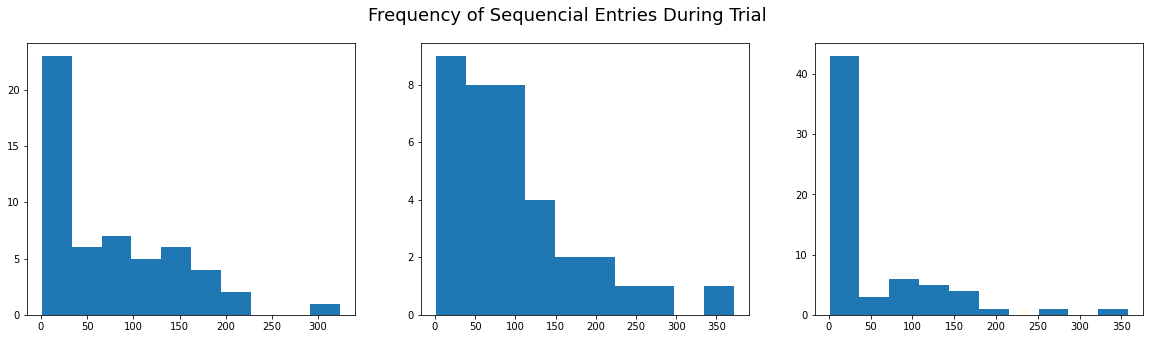

In [47]:
f, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].hist(groups(arms['A']))
ax[1].hist(groups(arms['B']))
ax[2].hist(groups(arms['C']))

plt.suptitle('Frequency of Sequencial Entries During Trial', fontsize=18)
plt.show()

In [48]:
# Setting a threshold of 30 since the framerate is 30fps



[14, 157, 182, 89, 36, 93, 140, 39, 105, 66, 89, 177, 45, 138, 55, 91, 111, 18, 47, 2, 33, 73, 10, 28, 31, 102, 16, 1, 7, 3, 2, 1, 8, 9, 112, 2, 24, 13, 1, 3, 1, 1, 156, 27, 200, 324, 183, 101, 158, 65, 163, 145, 221, 90]


We need settle the time of the experiment to exclude the placement of the mouse in the maze. Also, we have to separate the habituation time from the trial.

In [15]:
frames_per_sec = 30 

total_time = 8*60*frames_per_sec
hab_time = 2*60*frames_per_sec
exp_time = 6*60*frames_per_sec

# Delete the first rows corresponding to the placement of the animal

placement_time = arms.shape[0] - total_time
arms.drop(arms.index[:placement_time], inplace=True)

# Separate habituation (hab) and experiment (exp) starting from the last frame up. (last frame -> 6 min before +  6min -> 8 min before) 

hab = arms.head(hab_time)
exp = arms.tail(exp_time)

print(hab.shape[0])
print('Habituation Time (min)', (hab.shape[0]/30)/60)
print(exp.shape[0])
print('Experiment Time (min)', (exp.shape[0]/30)/60)


3600
Habituation Time (min) 2.0
10800
Experiment Time (min) 6.0


### Spontaneous Alternations 

To calculate the alternations percentage, we should use the following formula:

**%alternations** = $100 \frac{nº of alterations}{total nº of arm entries} $

A high **%alternations** should indicate a good short-term memory while a low **%alternations** suggests a poor short-term memory.